In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 

# Dataset

Extraction of data sets

In [2]:
PR_dataset = pd.read_csv('new_pullreq.csv')
pd.set_option('display.max_columns', None)

In [3]:
PR_dataset

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,num_commit_comments,num_issue_comments,num_comments,num_participants,sloc,team_size,perc_external_contribs,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,churn_addition,churn_deletion,pr_comment_num,comment_num,perc_neg_emotion,perc_pos_emotion,perc_neu_emotion,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,hash_tag,at_tag,test_inclusion,description_length,bug_fix,ci_exists,ci_latency,ci_build_num,ci_test_passed,ci_failed_perc,ci_first_build_status,ci_last_build_status,language,fork_num,project_age,open_issue_num,pr_succ_rate,open_pr_num,first_response_time,pushed_delta,acc_commit_num,first_pr,account_creation_days,core_member,contrib_gender,contrib_country,contrib_affiliation,contrib_open,contrib_cons,contrib_extra,contrib_agree,contrib_neur,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,contrib_first_emo,prior_review_num,inte_country,inte_affiliation,inte_open,inte_cons,inte_extra,inte_agree,inte_neur,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,inte_first_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation,open_diff,cons_diff,extra_diff,agree_diff,neur_diff,has_comments,has_participants,has_exchange,contrib_comment,inte_comment,reviewer_comment,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,0,0,1,1,0,0,1,0,1,1,1,14668.0,15,0.089869,79,745.04600,0.00000,0.000000,2070,14,1.000000,118,0,0,0,1,0.000000,0.000000,1.000000,1,0,0,0,0,1,0,0,4926,NaN,1.0,274.0,1.0,1.0,0.0,success,success,JavaScript,140,21,52,0.978469,25,237.0,196583.0,28,0,353,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,14,NaN,NaN,0.805841,0.629980,0.468658,0.658221,0.541352,0.0,0.0,1.0,neutral,0,28,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,1,1,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,0,0,1,1,0,0,0,0,2,2,1,474.0,2,0.014019,38,147.48200,16.18700,21.582700,1,299,1.000000,38,0,0,0,2,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1312,NaN,1.0,79.0,1.0,0.0,1.0,failure,failure,Python,1,6,1,1.000000,7,NaN,9.0,432,0,1092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,300,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,34921.0,5,0.256849,175,4.64599,0.00000,0.114012,5,81,0.987654,33,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,4,NaN,1.0,88.0,1.0,1.0,0.0,success,success,JavaScript,11,6,0,0.996324,10,NaN,5743.0,652,0,1884,1,male,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.000000,0.000000,NaN,94,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.0,0.0,NaN,0,505,0.428571,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,0,0,2,2,2,0,0,0,0,0,0,143159.0,5,0.014706,24,120.71000,0.00000,10.109800,2194,293,0.989761,222,110,3,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,1,94,NaN,1.0,489.0,1.0,1.0,0.0,success,success,Go,269,37,212,0.986523,29,NaN,978.0,1050,0,3489,1,male,canada,NaN,0.814346,0.633765,0.471257,0.666831,0.485847,0.0,0.000000,0.000000,NaN,679,NaN,NaN,0.818143,0.630804,0.466899,0.650931,0.496465,0.0,0.0,0.0,NaN,1,460,0.138889,NaN,NaN,0.003796,0.002961,0.004358,0.015900,0.010618,0,0,0,0,0,0,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,0,0,2,2,2,0,0,0,1,1,1,6247.0,2,0.173077,7,554.16800,28.61830,84.142200,131,3,1.000000,1,60,0,0,

Extracting the desired features out

In [4]:
study_dataset = PR_dataset[[
    'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'fork_num',
    'project_age', 'open_pr_num', 'acc_commit_num', 'prior_review_num',
    'churn_addition', 'part_num_code', 'churn_deletion', 'merged_or_not'
]]

In [5]:
study_dataset

,pushed_delta,pr_succ_rate,open_issue_num,fork_num,project_age,open_pr_num,acc_commit_num,prior_review_num,churn_addition,part_num_code,churn_deletion,merged_or_not
0,196583.0,0.978469,52,140,21,25,28,14,0,0,0,1
1,9.0,1.000000,1,1,6,7,432,139,0,0,0,0
2,5743.0,0.996324,0,11,6,10,652,94,0,0,0,1
3,978.0,0.986523,212,269,37,29,1050,679,110,0,3,1
4,517153.0,0.978495,93,64,25,9,10,67,60,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,18087.0,1.000000,2,0,20,0,414,187,0,0,0,1
3347933,431.0,0.965155,3359,2454,55,372,3389,1169,9,0,1,0
3347934,78766.0,0.992126,62,125,9,8,2,0,6,0,0,1
3347935,995650.0,0.991597,174,84,27,0,3,31,3,0,12,0


In [6]:
study_dataset.isna().sum()

pushed_delta        20542
pr_succ_rate        10203
open_issue_num          0
fork_num                0
project_age             0
open_pr_num             0
acc_commit_num          0
prior_review_num        0
churn_addition          0
part_num_code           0
churn_deletion          0
merged_or_not           0
dtype: int64

In [7]:
study_dataset.fillna(study_dataset.mean(),inplace=True)#均值填充

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
dataset=study_dataset.sample(n=10000, replace=False,random_state=1, axis=0)

# Data processing

Standardised handling of data（数据标准化）

In [9]:
std_scale = preprocessing.StandardScaler().fit(dataset[[
    'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'fork_num',
    'project_age', 'open_pr_num', 'acc_commit_num', 'prior_review_num',
    'churn_addition', 'part_num_code', 'churn_deletion'
]])
X = std_scale.transform(dataset[[
    'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'fork_num',
    'project_age', 'open_pr_num', 'acc_commit_num', 'prior_review_num',
    'churn_addition', 'part_num_code', 'churn_deletion'
]])  #标准化过后的特征矩阵
Y = np.array(dataset['merged_or_not'])  #标签
cv = StratifiedKFold(n_splits=5, shuffle=False)  #交叉验证方式：分层交叉验证 80%训练集，20%测试集

# Calculate the model fraction function 

In [10]:
def score (model,dataset_X,dataset_Y):
        accuracy = cross_val_score(model, dataset_X, dataset_Y, scoring='accuracy', cv=cv)#交叉验证后的准确率
        f1_score = cross_val_score(model, dataset_X, dataset_Y, scoring='f1', cv=cv)#交叉验证后的f1分数
        auc = cross_val_score(model, dataset_X, dataset_Y,scoring='roc_auc', cv=cv)#交叉验证后的AUC
        print("accuracy mean:",accuracy.mean())#准确率的均值
        print("accuracy std dev:",accuracy.std())#准确率的标准差
        print("F1_score mean:",f1_score.mean())#f1的均值
        print("F1_score std dev:",f1_score.std())#f1的标准差
        print("AUC:",auc.mean())#AUC的均值

#  logistic regression model

Before feature refinement（特征细化前）

In [11]:
lr_L1 = linear_model.LogisticRegression(penalty='l1',
                                        solver='liblinear',
                                        multi_class='ovr',
                                        )  #L1逻辑回归模型实例化
lr_L2 = linear_model.LogisticRegression(penalty='l2',
                                        solver='liblinear',
                                        multi_class='ovr',
                                        )  #L2逻辑回归模型实例化

In [12]:
score(lr_L1,X,Y)

accuracy mean: 0.8154999999999999
accuracy std dev: 0.003114482300479483
F1_score mean: 0.8977290423134001
F1_score std dev: 0.0019230424619887528
AUC: 0.6233204463125156


In [13]:
score(lr_L2,X,Y)

accuracy mean: 0.8154999999999999
accuracy std dev: 0.003114482300479483
F1_score mean: 0.8977290423134001
F1_score std dev: 0.0019230424619887528
AUC: 0.6234839674225903


Refinement of features（特征细化）

In [14]:
newstudy_dataset = dataset#使用一个新的数据集进行特征细化

In [15]:
newstudy_dataset['fork_num'] = newstudy_dataset['fork_num'].apply(
    lambda x: np.log(x + 1))
newstudy_dataset['pushed_delta'] = newstudy_dataset['pushed_delta'].apply(
    lambda x: np.log(x + 1))

In [16]:
newstudy_dataset#特征细化之后的数据集

,pushed_delta,pr_succ_rate,open_issue_num,fork_num,project_age,open_pr_num,acc_commit_num,prior_review_num,churn_addition,part_num_code,churn_deletion,merged_or_not
2133696,9.418411,0.988979,83,5.937536,29,21,485,454,22,2,23,1
1991211,10.393018,0.976009,158,5.135798,53,41,694,65,340,0,3,1
2403252,12.753732,0.988636,84,1.791759,12,3,45,22,36,0,38,1
2225756,11.044728,0.982301,24,2.564949,13,6,1,0,0,0,0,0
1813313,13.770096,0.991453,98,2.772589,36,2,51,46,8,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1935206,12.962296,0.985786,24,2.484907,85,18,68,3,22,1,22,1
1384007,12.428304,1.000000,11,1.098612,5,0,87,17,0,0,0,1
1072031,10.794543,0.969388,34,1.791759,29,10,51,23,33,0,5,1
506785,13.993298,1.000000,49,0.000000,13,6,13,13,151,2,84,1


In [17]:
new_std_scale = preprocessing.StandardScaler().fit(newstudy_dataset[[
    'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'fork_num',
    'project_age', 'open_pr_num', 'acc_commit_num', 'prior_review_num',
    'churn_addition', 'part_num_code', 'churn_deletion'
]])  #对特征细化后的数据集进行标准化
new_X = new_std_scale.transform(newstudy_dataset[[
    'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'fork_num',
    'project_age', 'open_pr_num', 'acc_commit_num', 'prior_review_num',
    'churn_addition', 'part_num_code', 'churn_deletion'
]])
new_Y = np.array(newstudy_dataset['merged_or_not'])
cv = StratifiedKFold(n_splits=5, shuffle=False)  #交叉验证方式：分层交叉验证 80%训练集，20%测试集

After feature refinement

In [18]:
score(lr_L1,new_X,new_Y)

accuracy mean: 0.8180999999999999
accuracy std dev: 0.0022891046284519235
F1_score mean: 0.8993972783340836
F1_score std dev: 0.0012546360388174342
AUC: 0.6436347739320653


In [19]:
score(lr_L2,new_X,new_Y)

accuracy mean: 0.8181
accuracy std dev: 0.0023958297101422093
F1_score mean: 0.8993862500896773
F1_score std dev: 0.0013060383150846576
AUC: 0.6436581340906474


网格调参

In [20]:
tol = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = dict(C=C, tol=tol)#打包成字典
log_grid_search = GridSearchCV(lr_L2, param_grid, scoring='accuracy', cv=cv)#网格调参
log_grid_result = log_grid_search.fit(new_X, new_Y)
log_means = log_grid_result.cv_results_['mean_test_score']
log_params = log_grid_result.cv_results_['params']
for mean, param in zip(log_means, log_params):
    print("%f  with:   %r" % (mean, param))

0.817400  with:   {'C': 0.001, 'tol': 0.001}
0.817400  with:   {'C': 0.001, 'tol': 0.01}
0.817400  with:   {'C': 0.001, 'tol': 0.1}
0.817100  with:   {'C': 0.001, 'tol': 1.0}
0.183500  with:   {'C': 0.001, 'tol': 10.0}
0.183500  with:   {'C': 0.001, 'tol': 100.0}
0.818000  with:   {'C': 0.01, 'tol': 0.001}
0.817900  with:   {'C': 0.01, 'tol': 0.01}
0.817800  with:   {'C': 0.01, 'tol': 0.1}
0.817000  with:   {'C': 0.01, 'tol': 1.0}
0.183500  with:   {'C': 0.01, 'tol': 10.0}
0.183500  with:   {'C': 0.01, 'tol': 100.0}
0.818200  with:   {'C': 0.1, 'tol': 0.001}
0.818300  with:   {'C': 0.1, 'tol': 0.01}
0.818400  with:   {'C': 0.1, 'tol': 0.1}
0.817000  with:   {'C': 0.1, 'tol': 1.0}
0.183500  with:   {'C': 0.1, 'tol': 10.0}
0.183500  with:   {'C': 0.1, 'tol': 100.0}
0.818100  with:   {'C': 1.0, 'tol': 0.001}
0.818000  with:   {'C': 1.0, 'tol': 0.01}
0.818100  with:   {'C': 1.0, 'tol': 0.1}
0.817000  with:   {'C': 1.0, 'tol': 1.0}
0.183500  with:   {'C': 1.0, 'tol': 10.0}
0.183500  with:  

In [21]:
means_plt=log_means.reshape((6,6))#将列表变成一个（6，6）的矩阵

In [22]:
means_plt#排列组合参数得出来的平均准确率

array([[0.8174, 0.8174, 0.8174, 0.8171, 0.1835, 0.1835],
       [0.818 , 0.8179, 0.8178, 0.817 , 0.1835, 0.1835],
       [0.8182, 0.8183, 0.8184, 0.817 , 0.1835, 0.1835],
       [0.8181, 0.818 , 0.8181, 0.817 , 0.1835, 0.1835],
       [0.8181, 0.818 , 0.8181, 0.817 , 0.1835, 0.1835],
       [0.8181, 0.818 , 0.8181, 0.817 , 0.1835, 0.1835]])

In [23]:
log_params#排列的参数组合

[{'C': 0.001, 'tol': 0.001},
 {'C': 0.001, 'tol': 0.01},
 {'C': 0.001, 'tol': 0.1},
 {'C': 0.001, 'tol': 1.0},
 {'C': 0.001, 'tol': 10.0},
 {'C': 0.001, 'tol': 100.0},
 {'C': 0.01, 'tol': 0.001},
 {'C': 0.01, 'tol': 0.01},
 {'C': 0.01, 'tol': 0.1},
 {'C': 0.01, 'tol': 1.0},
 {'C': 0.01, 'tol': 10.0},
 {'C': 0.01, 'tol': 100.0},
 {'C': 0.1, 'tol': 0.001},
 {'C': 0.1, 'tol': 0.01},
 {'C': 0.1, 'tol': 0.1},
 {'C': 0.1, 'tol': 1.0},
 {'C': 0.1, 'tol': 10.0},
 {'C': 0.1, 'tol': 100.0},
 {'C': 1.0, 'tol': 0.001},
 {'C': 1.0, 'tol': 0.01},
 {'C': 1.0, 'tol': 0.1},
 {'C': 1.0, 'tol': 1.0},
 {'C': 1.0, 'tol': 10.0},
 {'C': 1.0, 'tol': 100.0},
 {'C': 10.0, 'tol': 0.001},
 {'C': 10.0, 'tol': 0.01},
 {'C': 10.0, 'tol': 0.1},
 {'C': 10.0, 'tol': 1.0},
 {'C': 10.0, 'tol': 10.0},
 {'C': 10.0, 'tol': 100.0},
 {'C': 100.0, 'tol': 0.001},
 {'C': 100.0, 'tol': 0.01},
 {'C': 100.0, 'tol': 0.1},
 {'C': 100.0, 'tol': 1.0},
 {'C': 100.0, 'tol': 10.0},
 {'C': 100.0, 'tol': 100.0}]

In [24]:
log_grid_result.best_params_#最佳的参数

{'C': 0.1, 'tol': 0.1}

Text(0.5, 1.0, 'This is a title')

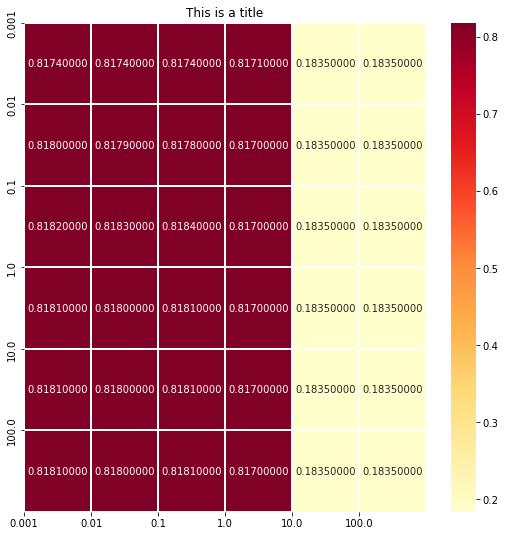

In [25]:
import seaborn as sns
import numpy as np
import pandas as pd

a = np.random.rand(4, 3)
fig, ax = plt.subplots(figsize=(9, 9))
#二维的数组的热力图，横轴和数轴的ticklabels要加上去的话，既可以通过将array转换成有column
#和index的DataFrame直接绘图生成，也可以后续再加上去。后面加上去的话，更灵活，包括可设置labels大小方向等。
sns.heatmap(means_plt,
            annot=True,
            cmap="YlOrRd",
            ax=ax,
            linewidths=0.05,
            fmt='.8f')
#sns.heatmap(np.round(a,2), annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True,
#            square=True, cmap="YlGnBu")
ax.set_yticks(range(len(C)))
ax.set_yticklabels(C)
ax.set_xticks(range(len(tol)))
ax.set_xticklabels(tol)
#增加标题

#c=colorbar;
#set(c,'tickdir','out')  % 朝外
#set(c,'YTick',-0.6:0.3:0.6); %色标值范围及显示间隔
#set(c,'YTickLabel',{'-0.6','-0.3','0.0','0.3','0.6'}) %具体刻度赋值
plt.title("This is a title")

# Mapping the learning curve

In [26]:
new_lr_L2 = linear_model.LogisticRegression(penalty='l2',
                                            solver='liblinear',
                                            multi_class='ovr',
                                            C=0.001,
                                            tol=0.1)  #L2逻辑回归模型实例化

In [27]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

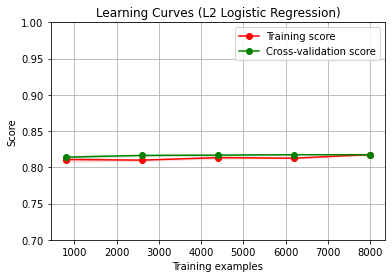

In [28]:
title = r"Learning Curves (L2 Logistic Regression)"
plot_learning_curve(new_lr_L2, title, new_X, Y, ylim=(0.7, 1), cv=cv, n_jobs=1)

# Decision trees and random forests (default parameters)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Dec_tree = DecisionTreeClassifier()#决策树模型
Random_forest = RandomForestClassifier(n_estimators=10,n_jobs=1)#随机森林模型

In [30]:
score(Dec_tree,new_X,new_Y)

accuracy mean: 0.7555
accuracy std dev: 0.006549809157525115
F1_score mean: 0.8495388870308378
F1_score std dev: 0.005187251010642213
AUC: 0.6124012407581373


In [31]:
score(Random_forest,new_X,new_Y)

accuracy mean: 0.8282
accuracy std dev: 0.004995998398718723
F1_score mean: 0.8995277804184445
F1_score std dev: 0.005917289761206496
AUC: 0.7182304346157504


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

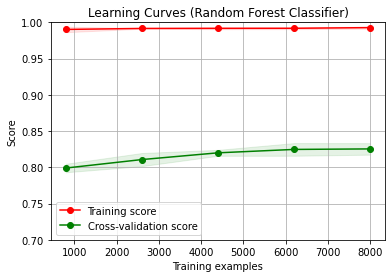

In [32]:
title = r"Learning Curves (Random Forest Classifier)"
plot_learning_curve(Random_forest, title, new_X, Y, ylim=(0.7, 1), cv=cv, n_jobs=1)#n_jobs是用来调整线程数量的

# Support vector machines (RBF kernel)

In [33]:
import sklearn.svm as sk_svm
svm_rbf = sk_svm.SVC(C=1.0,kernel='rbf',gamma='auto')#svm模型

由于svm是单线程的模型，因为数据集特别大，导致运行时间特别长，要想办法减小数据集。

In [46]:
score(svm_rbf,new_X,new_Y)

accuracy mean: 0.8221999999999999
accuracy std dev: 0.003544009029333873
F1_score mean: 0.9014640814276975
F1_score std dev: 0.0019101328710382295
AUC: 0.6496787143903583


In [44]:
gamma = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
kernel=['rbf']
param_grid = dict(C=C, gamma=gamma,kernel=kernel)
svm_grid_search = GridSearchCV(svm_rbf, param_grid, scoring='accuracy', cv=cv)
svm_grid_result = svm_grid_search.fit(new_X, new_Y)
svm_means = svm_grid_result.cv_results_['mean_test_score']
svm_params = svm_grid_result.cv_results_['params']
for mean, param in zip(svm_means, svm_params):
    print("%f  with:   %r" % (mean, param))

0.816500  with:   {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.816500  with:   {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.81650

In [36]:
print("Grid search optimal score：",svm_grid_search.best_score_)
print("Grid search for optimal parameter combinations：\n",svm_grid_search.best_params_)

Grid search optimal score： 0.8257999999999999
Grid search for optimal parameter combinations：
 {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}


In [37]:
svm_rbf_P = sk_svm.SVC(C=10.0,kernel='rbf',gamma=0.1)

In [38]:
score(svm_rbf_P,new_X,new_Y)

accuracy mean: 0.8257999999999999
accuracy std dev: 0.0031080540535840255
F1_score mean: 0.9026397971539323
F1_score std dev: 0.0016181490934914324
AUC: 0.6537323693374558


In [39]:
svm_means_plt=svm_means.reshape((6,6))

Text(0.5, 1.0, 'This is a title')

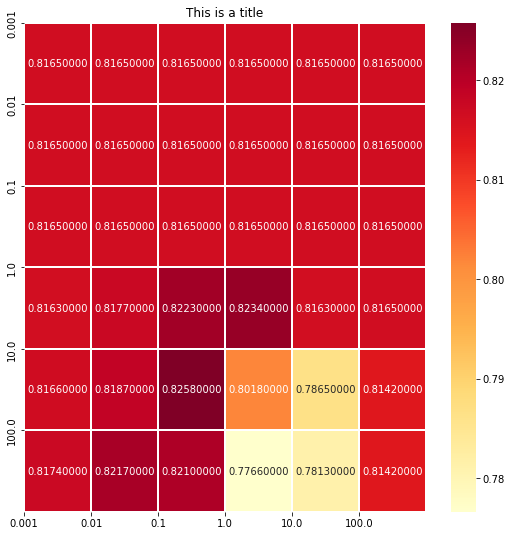

In [42]:
a = np.random.rand(4, 3)
fig, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(svm_means_plt,
            annot=True,
            cmap="YlOrRd",
            ax=ax,
            linewidths=0.05,
            fmt='.8f')

ax.set_yticks(range(len(C)))
ax.set_yticklabels(C)
ax.set_xticks(range(len(tol)))
ax.set_xticklabels(tol)

plt.title("This is a title")

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

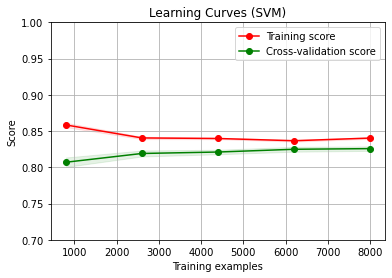

In [43]:
title = r"Learning Curves (SVM)"
plot_learning_curve(svm_rbf_P, title, new_X,new_Y, ylim=(0.7, 1), cv=cv, n_jobs=1)